In [5]:
using Pkg;
Pkg.activate(".");
Pkg.instantiate();

  Activating project at `~/Repos/DoingRightNow-Analysis`


In [2]:
using MLJ, Plots

# Pull and wrangle data

The function for pulling and wrangling data is in the `models/DataWrangle.jl` module. It pulls data from the file, does some labelling, and ensures fields have the appropriate `scitype`.

The data is split into training predictors and target -- `X` and `y` -- as well as testing predictors and target -- `X_test` and `y_test`.

In [3]:
include("./models/DataWrangle.jl")

Main.DataWrangle

In [4]:
using .DataWrangle

In [5]:
y, X, y_test, X_test = pull_and_clean_data();

## Find the right model to use

Pulling a list of models that we can use. We'll need to one hot encode the data first to see the appropriate list.

In [7]:
# One Hot Encode X into a new object called X2.
ohe = OneHotEncoder(drop_last=true)
mach = fit!(machine(ohe, X), verbosity=0)
X2 = MLJ.transform(mach, X)

# Search for the available models.
for m in models(matching(X2,y))
    if m.prediction_type == :probabilistic
        println(rpad(m.name, 30), "($(m.package_name))")
    end
end

AdaBoostClassifier            (MLJScikitLearnInterface)
AdaBoostStumpClassifier       (DecisionTree)
BaggingClassifier             (MLJScikitLearnInterface)
BayesianLDA                   (MLJScikitLearnInterface)
BayesianLDA                   (MultivariateStats)
BayesianQDA                   (MLJScikitLearnInterface)
BayesianSubspaceLDA           (MultivariateStats)
CatBoostClassifier            (CatBoost)
ConstantClassifier            (MLJModels)
DecisionTreeClassifier        (BetaML)
DecisionTreeClassifier        (DecisionTree)
DummyClassifier               (MLJScikitLearnInterface)
EvoTreeClassifier             (EvoTrees)
ExtraTreesClassifier          (MLJScikitLearnInterface)
GaussianNBClassifier          (MLJScikitLearnInterface)
GaussianNBClassifier          (NaiveBayes)
GaussianProcessClassifier     (MLJScikitLearnInterface)
GradientBoostingClassifier    (MLJScikitLearnInterface)
KNNClassifier                 (NearestNeighborModels)
KNeighborsClassifier          (MLJScikitLearnI

That's a big variety of models to choose from.

We'll start with `RandomForestClassifior`.

## Random Forest Classifier

Note, a lot of this is adopted from [this MLJ documentation](https://alan-turing-institute.github.io/MLJ.jl/dev/tuning_models/#Tuning-multiple-nested-hyperparameters) and to a lesser extent from [this slightly outdated tutorial](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/ensembles-2/).

The `DecisionTreeClassifier` from the `BetaML` package works with no encoding or transformation. But it takes a very long time to run. We'll try setting up a pipeline to transform the data ard run the `DecisionTreeClassifier` from the `DecisionTree` package.

In [6]:
# Load models from packages.
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree

# Initialize multiclass F1 loss function.
multiclassf1 = MulticlassFScore()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/mph/.julia/packages/MLJModels/UM8fF/src/loading.jl:159


import MLJDecisionTreeInterface ✔

MulticlassFScore(
  β = 1.0, 
  average = MLJBase.MacroAvg(), 
  return_type = OrderedCollections.LittleDict)

In [7]:
# Define a new model struct.
mutable struct ATUSClassifier <: ProbabilisticNetworkComposite
    preprocessor    # This part does the pre-processing.
    classifier    # This part does the classifying
end

# Wrap the above steps into a function called `prefit`
import MLJBase    # We need to import in order to overload `MLJBase.prefit`


function MLJBase.prefit(composite::ATUSClassifier, verbosity, X, y)

    verbosity > 0 && @info "Running ATUSClassifier."

    # Define data input nodes. We just want the training set.
    Xs = source(X)
    ys = source(y)

    # First machine -- We substitute the symbols in the struct defined above for the model objects.
    mach_ohe = machine(:preprocessor, Xs)
    X_ohe = MLJ.transform(mach_ohe, Xs)    # `transform` has duplicated namespace. So we specify `MLJ.transform`
    mach_classifier = machine(:classifier, X_ohe, ys)
    ρ̂ = predict(mach_classifier, X_ohe)    # ρ̂ (rho hat) is the CategoricalDistribution produced for each instance.
    ŷ = predict_mode(mach_classifier, X_ohe)    # ŷ is the most likely class.
    
    return (; predict=ρ̂, predict_mode=ŷ, acceleration=CPUThreads())
end
#fit!(mach, rows=train, verbosity=0)
#estimates = evaluate!(mach, measure=cross_entropy)    # Equal to fit! then predict! then calling the measure.

In [8]:
# Run the model for a custom rolled random forest.
one_hot_encoder = OneHotEncoder(drop_last=true)
tree = DecisionTreeClassifier(n_subfeatures=3)
ensemble_model = EnsembleModel(model=tree, n=20)
atus_classifier = ATUSClassifier(one_hot_encoder, ensemble_model)
# Fit the machine and predict the most likely class.
mach = machine(atus_classifier, X, y) |> fit!
ŷ = predict_mode(mach, X_test)

┌ Info: Training machine(ATUSClassifier(preprocessor = OneHotEncoder(features = Symbol[], …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Running ATUSClassifier.
└ @ Main /Users/mph/Repos/DoingRightNow-Analysis/atus_ml_model.ipynb:13


┌ Info: Training machine(:preprocessor, …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Spawning 50 sub-features to one-hot encode feature :GESTFIPS_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878


┌ Info: Spawning 15 sub-features to one-hot encode feature :HEFAMINC_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 1 sub-features to one-hot encode feature :PEMARITL_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 2 sub-features to one-hot encode feature :HETENURE_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 6 sub-features to one-hot encode feature :TUDIARYDAY_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878


┌ Info: Training machine(:classifier, …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492


Training ensemble:  10%[=====>                                            ]  ETA: 0:00:55

Training ensemble:  15%[=======>                                          ]  ETA: 0:01:02

Training ensemble:  20%[==========>                                       ]  ETA: 0:01:03

Training ensemble:  25%[============>                                     ]  ETA: 0:01:02

Training ensemble:  30%[===============>                                  ]  ETA: 0:01:00

Training ensemble:  35%[=================>                                ]  ETA: 0:00:56

Training ensemble:  40%[====================>                             ]  ETA: 0:00:53

Training ensemble:  45%[======================>                           ]  ETA: 0:00:49

Training ensemble:  50%[=========================>                        ]  ETA: 0:00:45

Training ensemble:  55%[===========================>                      ]  ETA: 0:00:41

Training ensemble:  60%[==============================>                   ]  ETA: 0:00:37

Training ensemble:  65%[================================>                 ]  ETA: 0:00:32

Training ensemble:  70%[===================================>              ]  ETA: 0:00:28

Training ensemble:  75%[=====================================>            ]  ETA: 0:00:23

Training ensemble:  80%[========================================>         ]  ETA: 0:00:19

Training ensemble:  85%[==========================================>       ]  ETA: 0:00:14

Training ensemble:  90%[=============================================>    ]  ETA: 0:00:09

Training ensemble:  95%[===============================================>  ]  ETA: 0:00:05

Training ensemble: 100%[==================================================] Time: 0:01:34


523411-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1203
 101
 101
 1203
 101
 101
 101
 1201
 101
 101
 ⋮
 101
 101
 101
 101
 101
 101
 101
 101
 101

In [9]:
# score the model.
multiclassf1(ŷ, y_test)

0.19322192449032596

That takes way too long. I even tried it on my gaming PC and throwing compute at it doesn't fix the problem.

Let's try the out-of-the-box RandomForest model.

# Out-of-the-box Random Forest

In [66]:
# Load models from packages.
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/mph/.julia/packages/MLJModels/UM8fF/src/loading.jl:159


MLJDecisionTreeInterface.RandomForestClassifier

In [68]:
# Define a new model struct.
mutable struct ATUSRandomForest <: ProbabilisticNetworkComposite
    preprocessor    # This part does the pre-processing.
    classifier    # This part does the classifying
end

# Create prefit
import MLJBase
function MLJBase.prefit(composite::ATUSRandomForest, verbosity, X, y)

    verbosity > 0 && @info "Running ATUSRandomForest"
    
    # Learning network
    Xs = source(X)
    ys = source(y)
    mach1 = machine(:preprocessor, Xs)
    x = MLJ.transform(mach1, Xs)
    mach2 = machine(:classifier, x, ys)
    ρ̂ = predict(mach2, x)
    ŷ = predict_mode(mach2, x)

    

    # return "learning network interface":
    return (; predict=ρ̂, predict_mode=ŷ)

end

In [70]:
one_hot_encoder = OneHotEncoder()
forest = RandomForestClassifier(
    n_subfeatures=12,
    sampling_fraction=0.3,    # We have lots of data. Only use 30%.
    max_depth=10,
    rng=71
    )

atus_random_forest = ATUSRandomForest(one_hot_encoder,forest)

mach = machine(atus_random_forest, X, y)
fit!(mach)

ŷ = predict_mode(mach, X_test)

┌ Info: Training machine(ATUSRandomForest(preprocessor = OneHotEncoder(features = Symbol[], …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Running ATUSRandomForest
└ @ Main /Users/mph/Repos/DoingRightNow-Analysis/atus_ml_model.ipynb:5


┌ Info: Training machine(:preprocessor, …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Spawning 51 sub-features to one-hot encode feature :GESTFIPS_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 16 sub-features to one-hot encode feature :HEFAMINC_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 2 sub-features to one-hot encode feature :PEMARITL_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 3 sub-features to one-hot encode feature :HETENURE_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 7 sub-features to one-hot encode feature :TUDIARYDAY_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Training machine(:classifier, …).
└ @ MLJBase 

523411-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1203
 1203
 1203
 101
 1203
 101
 101
 501
 101
 1203
 ⋮
 1203
 101
 1203
 1203
 1203
 1203
 1203
 501
 501

In [93]:
multiclassf1(ŷ, y_test)

0.007395815652960273

This is significantly lower than the 0.19 we got above. We used different hyperparameters.

# Clustering and RandomForest

The predictor space is very high dimensional. It may be useful to cluster it into something smaller.

In [101]:
using DataFrames: ncol
num_x_ohe_features = ncol(transform(fit!(machine(OneHotEncoder(drop_last=true), X)), X))


┌ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Spawning 50 sub-features to one-hot encode feature :GESTFIPS_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 15 sub-features to one-hot encode feature :HEFAMINC_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 1 sub-features to one-hot encode feature :PEMARITL_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 2 sub-features to one-hot encode feature :HETENURE_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 6 sub-features to one-hot encode feature :TUDIARYDAY_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878


76

There are 76 features in the transformed data. We can try a smaller number of clusters.

In [108]:
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree
KMeans = @load KMeans pkg=Clustering verbosity=0

# Define a new model struct.
mutable struct ATUSClusterClassifier <: ProbabilisticNetworkComposite
    one_hot_encoder    # This part does the pre-processing.
    continuous_encoder    # Force any remaining non-continuous to continuous.
    clusterer    # This part clusters the predictors.
    classifier    # This part does the classifying
end

import MLJBase

# Create prefit
function MLJBase.prefit(composite::ATUSClusterClassifier, verbosity, X, y)

    verbosity > 0 && @info "Running ATUSClusterClassifier composite model."

    # Learning network
    Xs = source(X)
    ys = source(y)

    ## Transform categoricals using one-hot-encoding.
    mach_ohe = machine(:one_hot_encoder, Xs)
    X_ohe = MLJ.transform(mach_ohe, Xs)
    
    ## Transform everything else to continuous.
    mach_cont = machine(:continuous_encoder, X_ohe)
    X_cont = MLJ.transform(mach_cont, X_ohe)
    
    ## Cluster predictors. Produces a table of k columns with distances.
    mach_clust = machine(:clusterer, X_cont)
    X_clust = MLJ.transform(mach_clust, X_cont)
    
    ## Run the classifier and predict.
    mach_class = machine(:classifier, X_clust, ys)
    ρ̂ = predict(mach_class, X_clust)
    ŷ = predict_mode(mach_class, X_clust)

    # return "learning network interface":
    return (; predict=ρ̂, predict_mode=ŷ, acceleration=CPUThreads())

end


import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/mph/.julia/packages/MLJModels/UM8fF/src/loading.jl:159


In [109]:
one_hot_encoder = OneHotEncoder(ordered_factor=false, drop_last=true)
continuous_encoder = ContinuousEncoder()
kmeans = KMeans(k=20)    # Should be less than the 76 features in the original X.
forest = RandomForestClassifier(
    sampling_fraction=0.3,    # We have lots of data. Only use 30%.
    max_depth=10,
    rng=71
    )

atus_cluster_classifier = ATUSClusterClassifier(
    one_hot_encoder, 
    continuous_encoder, 
    kmeans,
    forest)

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 20, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = 10, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 100, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

In [110]:
mach = machine(atus_cluster_classifier, X, y) |> fit!
ŷ = predict_mode(mach, X_test)

┌ Info: Training machine(ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Running ATUSClusterClassifier composite model.
└ @ Main /Users/mph/Repos/DoingRightNow-Analysis/atus_ml_model.ipynb:17
┌ Info: Training machine(:one_hot_encoder, …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Spawning 50 sub-features to one-hot encode feature :GESTFIPS_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 1 sub-features to one-hot encode feature :PEMARITL_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 2 sub-features to one-hot encode feature :HETENURE_label.
└ @ MLJModels /Users/mph/.julia/packages/MLJModels/UM8fF/src/builtins/Transformers.jl:878
┌ Info: Spawning 6 sub-features to one-hot encode feature :TUDIARYDAY_la

┌ Info: Training machine(:clusterer, …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492


┌ Info: Training machine(:classifier, …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492


523411-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 101
 101
 101
 101
 101
 101
 101
 101
 101
 101
 ⋮
 101
 101
 101
 101
 101
 101
 101
 101
 101

In [111]:
multiclassf1(ŷ, y_test)

0.016148832271837804

Still not great. Before we abandon the clustering. Let's try a grid search on k-means.

# Tuning K-Means Parameter

In [112]:
atus_cluster_classifier

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 20, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = 10, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 100, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

In [120]:
r_k = range(atus_cluster_classifier, :(clusterer.k), lower=5, upper=70, scale=:linear)
self_tuning_atus_cluster_classifier = TunedModel(model=atus_cluster_classifier,
										tuning=Grid(resolution=5),
									  	resampling=Holdout(fraction_train=0.6, rng=71),
									  	range=r_k,
									  	measure=multiclassf1)

ProbabilisticTunedModel(
  model = ATUSClusterClassifier(
        one_hot_encoder = OneHotEncoder(features = Symbol[], …), 
        continuous_encoder = ContinuousEncoder(drop_last = false, …), 
        clusterer = KMeans(k = 20, …), 
        classifier = RandomForestClassifier(max_depth = 10, …)), 
  tuning = Grid(
        goal = nothing, 
        resolution = 5, 
        shuffle = true, 
        rng = Random._GLOBAL_RNG()), 
  resampling = Holdout(
        fraction_train = 0.6, 
        shuffle = true, 
        rng = Random.MersenneTwister(71)), 
  measure = MulticlassFScore(
        β = 1.0, 
        average = MLJBase.MacroAvg(), 
        return_type = OrderedCollections.LittleDict), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = NumericRange(5 ≤ clusterer.k ≤ 70; origin=37.5, unit=32.5), 
  selection_heuristic = MLJTuning.NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = nothing, 
  acceleration = CPU1{Nothing}(nothing), 
  

In [122]:
mach_self_tuning_atus_cluster_classifier = machine(self_tuning_atus_cluster_classifier, X, y) |> fit!

┌ Info: Training machine(ProbabilisticTunedModel(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/mph/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727


Evaluating over 5 metamodels:  40%[==========>              ]  ETA: 0:15:12

Evaluating over 5 metamodels:  60%[===============>         ]  ETA: 0:10:53

Evaluating over 5 metamodels:  80%[====================>    ]  ETA: 0:06:13

Evaluating over 5 metamodels: 100%[=========================] Time: 0:49:40


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …)
  args: 
    1:	Source @429 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{51}}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{7}}, AbstractVector{OrderedFactor{16}}}}
    2:	Source @306 ⏎ AbstractVector{Multiclass{99}}


In [123]:
fitted_params(mach_self_tuning_atus_cluster_classifier).best_model

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 54, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = 10, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 100, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

In [124]:
report(mach_self_tuning_atus_cluster_classifier).best_history_entry

(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …),
 measure = MulticlassFScore{Float64, MLJBase.MacroAvg, OrderedCollections.LittleDict}[MulticlassFScore(β = 1.0, …)],
 measurement = [0.016273185675579324],
 per_fold = [[0.016273185675579324]],)

In [150]:
tmp_1[:,1]

5-element Vector{Any}:
  5
 38
 21
 54
 70

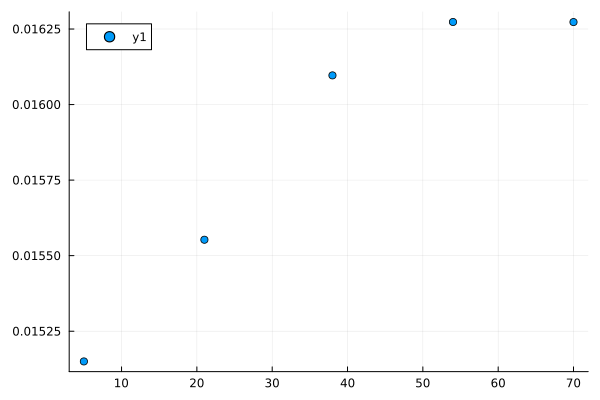

In [153]:
tmp_1 = report(mach_self_tuning_atus_cluster_classifier).plotting.parameter_values[:,1]
tmp_2 = report(mach_self_tuning_atus_cluster_classifier).plotting.measurements
scatter(tmp_1,tmp_2)

Once more, looking at the 50-70 range.

┌ Info: Training machine(ProbabilisticTunedModel(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/mph/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727


Evaluating over 5 metamodels:   0%[>                        ]  ETA: N/A

Evaluating over 5 metamodels:  20%[=====>                   ]  ETA: 0:34:14

Evaluating over 5 metamodels:  40%[==========>              ]  ETA: 0:27:49

Evaluating over 5 metamodels:  60%[===============>         ]  ETA: 0:17:54

Evaluating over 5 metamodels:  80%[====================>    ]  ETA: 0:09:12

Evaluating over 5 metamodels: 100%[=========================] Time: 0:46:43


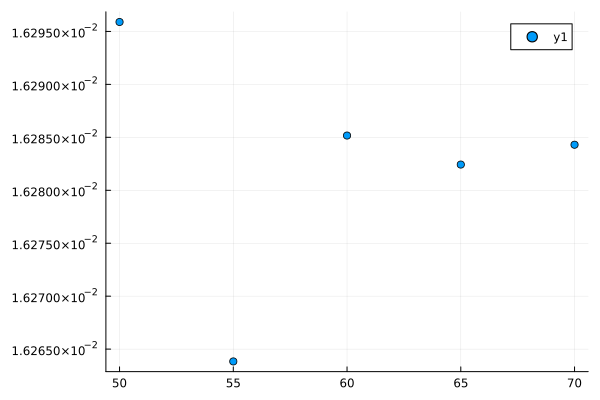

In [154]:
r_k = range(atus_cluster_classifier, :(clusterer.k), lower=50, upper=70, scale=:linear)
self_tuning_atus_cluster_classifier = TunedModel(model=atus_cluster_classifier,
	tuning=Grid(resolution=5),
	resampling=Holdout(fraction_train=0.6, rng=71),
	range=r_k,
	measure=multiclassf1)
mach_self_tuning_atus_cluster_classifier = machine(self_tuning_atus_cluster_classifier, X, y) |> fit!

tmp_1 = report(mach_self_tuning_atus_cluster_classifier).plotting.parameter_values[:,1]
tmp_2 = report(mach_self_tuning_atus_cluster_classifier).plotting.measurements
scatter(tmp_1,tmp_2)

I'm not super confident in this. Ideally we would have bootstrapped some confidence intervals. I'm not convinced the "higher" values are really higher. 

Still, most of these F1 scores are a little higher than the original. I'm going to go with `k=50`.

We're still getting a pretty low F1 score. Let's move on to tuning the Random Forest parameters and see if that helps.

# Tuning Random Forest Parameters

Let's start with the number of trees in the random forest. We'll need to re-create the learning network with our chosen k=50 model.

In [162]:
one_hot_encoder = OneHotEncoder(ordered_factor=false, drop_last=true)
continuous_encoder = ContinuousEncoder()
kmeans = KMeans(k=50)    # Should be less than the 76 features in the original X.
forest = RandomForestClassifier(
    sampling_fraction=0.3,    # We have lots of data. Only use 30%.
    n_trees=10,
    rng=71
    )

atus_cluster_classifier = ATUSClusterClassifier(
    one_hot_encoder, 
    continuous_encoder, 
    kmeans,
    forest)

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 50, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 10, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

┌ Info: Training machine(ProbabilisticTunedModel(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/mph/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727
Evaluating over 5 metamodels:   0%[>                        ]  ETA: N/A

Evaluating over 5 metamodels:  20%[=====>                   ]  ETA: 0:28:49

Evaluating over 5 metamodels:  40%[==========>              ]  ETA: 0:11:29

Evaluating over 5 metamodels:  60%[===============>         ]  ETA: 0:05:16

Evaluating over 5 metamodels:  80%[====================>    ]  ETA: 0:03:09

Evaluating over 5 metamodels: 100%[=========================] Time: 0:21:22


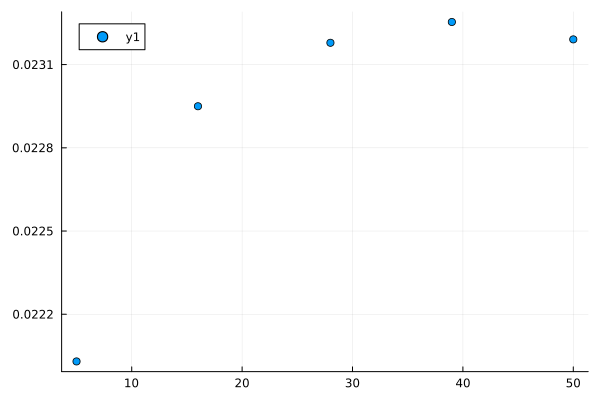

In [164]:
r_n_trees = range(atus_cluster_classifier, :(classifier.n_trees), lower=5, upper=50, scale=:linear)
self_tuning_atus_cluster_classifier = TunedModel(model=atus_cluster_classifier,
	tuning=Grid(resolution=5),
	resampling=Holdout(fraction_train=0.6, rng=71),
	range=r_n_trees,
	measure=multiclassf1)
mach_self_tuning_atus_cluster_classifier = machine(self_tuning_atus_cluster_classifier, X, y) |> fit!

tmp_1 = report(mach_self_tuning_atus_cluster_classifier).plotting.parameter_values[:,1]
tmp_2 = report(mach_self_tuning_atus_cluster_classifier).plotting.measurements
scatter(tmp_1,tmp_2)

Looks like `n_trees` around 40 gives us what we're looking for. If we wanted to, we could specify a more specific range of 30 to 50 and use a search algorithm. But this is a reasonable ballpark.

The next feature we'll tune is `max_depth`, the maximum depth of the trees. This default of `-1` maps to no limit on tree depth. Our model is likely complex, which would require deeper trees. But some of this complexity is reduced in the KNN preprocessing. Plus, setting smaller trees may speed up processing. Let's see what range we might want.

In [166]:
one_hot_encoder = OneHotEncoder(ordered_factor=false, drop_last=true)
continuous_encoder = ContinuousEncoder()
kmeans = KMeans(k=50)    # Should be less than the 76 features in the original X.
forest = RandomForestClassifier(
    sampling_fraction=0.3,    # We have lots of data. Only use 30%.
    n_trees=40,
    rng=71
    )

atus_cluster_classifier = ATUSClusterClassifier(
    one_hot_encoder, 
    continuous_encoder, 
    kmeans,
    forest)

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 50, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 40, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

┌ Info: Training machine(ProbabilisticTunedModel(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/mph/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727
Evaluating over 5 metamodels:   0%[>                        ]  ETA: N/A

Evaluating over 5 metamodels:  20%[=====>                   ]  ETA: 0:15:46

Evaluating over 5 metamodels:  40%[==========>              ]  ETA: 0:11:36

Evaluating over 5 metamodels:  60%[===============>         ]  ETA: 0:06:55

Evaluating over 5 metamodels:  80%[====================>    ]  ETA: 0:08:56

Evaluating over 5 metamodels: 100%[=========================] Time: 0:37:31


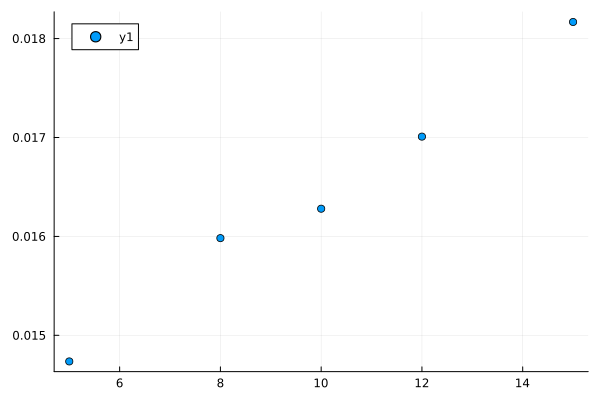

In [167]:
r_max_depth = range(atus_cluster_classifier, :(classifier.max_depth), lower=5, upper=15, scale=:linear)
self_tuning_atus_cluster_classifier = TunedModel(model=atus_cluster_classifier,
	tuning=Grid(resolution=5),
	resampling=Holdout(fraction_train=0.6, rng=71),
	range=r_max_depth,
	measure=multiclassf1)
mach_self_tuning_atus_cluster_classifier = machine(self_tuning_atus_cluster_classifier, X, y) |> fit!

tmp_1 = report(mach_self_tuning_atus_cluster_classifier).plotting.parameter_values[:,1]
tmp_2 = report(mach_self_tuning_atus_cluster_classifier).plotting.measurements
scatter(tmp_1,tmp_2)

This shows increasing performance as the `max_depth` increases.

This doesn't point toward an optimum. If I had to guess, I'd say increasing `max_depth` will eventually level out as it hits the natural maximum. Lets leave this at the default for now and turn our attention towards `n_subfeatures`.

The default for `n_subfeatures` is sqrt(#features), which is about 8 in our case. Lets fit a range between 2 and 10.

In [169]:
one_hot_encoder = OneHotEncoder(ordered_factor=false, drop_last=true)
continuous_encoder = ContinuousEncoder()
kmeans = KMeans(k=50)    # Should be less than the 76 features in the original X.
forest = RandomForestClassifier(
    sampling_fraction=0.3,    # We have lots of data. Only use 30%.
    n_trees=40,
    rng=71
    )

atus_cluster_classifier = ATUSClusterClassifier(
    one_hot_encoder, 
    continuous_encoder, 
    kmeans,
    forest)

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 50, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 40, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

┌ Info: Training machine(ProbabilisticTunedModel(model = ATUSClusterClassifier(one_hot_encoder = OneHotEncoder(features = Symbol[], …), …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/mph/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727
Evaluating over 5 metamodels:   0%[>                        ]  ETA: N/A

Evaluating over 5 metamodels:  20%[=====>                   ]  ETA: 0:26:13

Evaluating over 5 metamodels:  40%[==========>              ]  ETA: 0:14:14

Evaluating over 5 metamodels:  60%[===============>         ]  ETA: 0:26:42

Evaluating over 5 metamodels:  80%[====================>    ]  ETA: 0:14:44

Evaluating over 5 metamodels: 100%[=========================] Time: 1:03:19


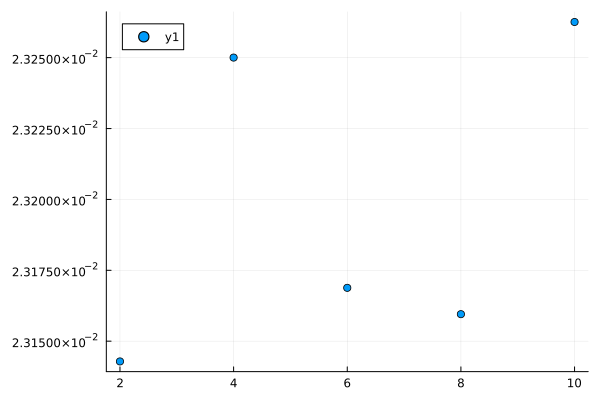

In [170]:
r_n_subfeatures = range(atus_cluster_classifier, :(classifier.n_subfeatures), lower=2, upper=10, scale=:linear)
self_tuning_atus_cluster_classifier = TunedModel(model=atus_cluster_classifier,
	tuning=Grid(resolution=5),
	resampling=Holdout(fraction_train=0.6, rng=71),
	range=r_n_subfeatures,
	measure=multiclassf1)

mach_self_tuning_atus_cluster_classifier = machine(self_tuning_atus_cluster_classifier, X, y) |> fit!

tmp_1 = report(mach_self_tuning_atus_cluster_classifier).plotting.parameter_values[:,1]
tmp_2 = report(mach_self_tuning_atus_cluster_classifier).plotting.measurements
scatter(tmp_1,tmp_2)

Weirdly multi-modal here. Again, ideally we would bootstrap some intervals on this. But computation is taking like an hour already. Still, let's try it on a version with `n_subfeatures=4`.

In [171]:
one_hot_encoder = OneHotEncoder(ordered_factor=false, drop_last=true)
continuous_encoder = ContinuousEncoder()
kmeans = KMeans(k=50)    # Should be less than the 76 features in the original X.
forest = RandomForestClassifier(
    sampling_fraction=0.3,    # We have lots of data. Only use 30%.
    n_trees=40,
    n_subfeatures=4,
    rng=71
    )

atus_cluster_classifier = ATUSClusterClassifier(
    one_hot_encoder, 
    continuous_encoder, 
    kmeans,
    forest)

ATUSClusterClassifier(
  one_hot_encoder = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = false, 
        ignore = false), 
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  clusterer = KMeans(
        k = 50, 
        metric = Distances.SqEuclidean(0.0), 
        init = :kmpp), 
  classifier = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 4, 
        n_trees = 40, 
        sampling_fraction = 0.3, 
        feature_importance = :impurity, 
        rng = 71))

In [172]:
atus_cluster_classifier_eval = evaluate(atus_cluster_classifier, X, y, resampling=CV(nfolds=5), measure=multiclassf1)

Evaluating over 5 folds:  40%[==========>              ]  ETA: 0:25:24

Evaluating over 5 folds:  60%[===============>         ]  ETA: 0:15:41

Evaluating over 5 folds:  80%[====================>    ]  ETA: 0:07:27

Evaluating over 5 folds: 100%[=========================] Time: 0:35:47


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────────────────────┬──────────────┬───────────────
│ measure                                        │ operation    │ measurement  ⋯
├────────────────────────────────────────────────┼──────────────┼───────────────
│ MulticlassFScore(                              │ predict_mode │ 0.00722      ⋯
│   β = 1.0,                                     │              │              ⋯
│   average = MLJBase.MacroAvg(),                │              │              ⋯
│   return_type = OrderedCollections.LittleDict) │              │              ⋯
└────────────────────────────────────────────────┴──────────────┴───────────────
                                                               2 columns omitted


In [173]:
atus_cluster_classifier_eval.per_fold

1-element Vector{Vector{Float64}}:
 [0.011295988704628081, 0.007274587266145907, 0.004410587131241159, 0.005701611408224299, 0.007440108952042697]

This seemed to do _much_ worse than the original. But I accidentally trained it on all the data.

# Tuning our original random forest

So, the weird thing is, all of these are under-performing the original random forest classifier we originally did. Let's try that again with cross validation. If it significantly outperforms the cluster classifier, we may drop the KNN clustering.

In [6]:
# Load models from packages.
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree

# Initialize multiclass F1 loss function.
multiclassf1 = MulticlassFScore()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/mph/.julia/packages/MLJModels/UM8fF/src/loading.jl:159


import MLJDecisionTreeInterface ✔

MulticlassFScore(
  β = 1.0, 
  average = MLJBase.MacroAvg(), 
  return_type = OrderedCollections.LittleDict)

In [11]:
# Define a new model struct.
mutable struct ATUSClassifier <: ProbabilisticNetworkComposite
    preprocessor    # This part does the pre-processing.
    classifier    # This part does the classifying
end

# Create prefit
import MLJBase
function MLJBase.prefit(composite::ATUSClassifier, verbosity, X, y)

    verbosity > 0 && @info "Running ATUSRandomForest"
    
    # Learning network
    Xs = source(X)
    ys = source(y)
    mach1 = machine(:preprocessor, Xs)
    x = MLJ.transform(mach1, Xs)
    mach2 = machine(:classifier, x, ys)
    ρ̂ = predict(mach2, x)
    ŷ = predict_mode(mach2, x)

    

    # return "learning network interface":
    return (; predict=ρ̂, predict_mode=ŷ)

end

In [12]:
# Run the model for a custom rolled random forest.
one_hot_encoder = OneHotEncoder(drop_last=true)
tree = DecisionTreeClassifier(n_subfeatures=3)
ensemble_model = EnsembleModel(model=tree, n=20)

atus_classifier = ATUSClassifier(one_hot_encoder, ensemble_model)

ATUSClassifier(
  preprocessor = OneHotEncoder(
        features = Symbol[], 
        drop_last = true, 
        ordered_factor = true, 
        ignore = false), 
  classifier = ProbabilisticEnsembleModel(
        model = DecisionTreeClassifier(max_depth = -1, …), 
        atomic_weights = Float64[], 
        bagging_fraction = 0.8, 
        rng = Random._GLOBAL_RNG(), 
        n = 20, 
        acceleration = CPU1{Nothing}(nothing), 
        out_of_bag_measure = Any[]))

In [13]:
r_n_trees = range(atus_classifier, :(classifier.n), lower=10, upper=30, scale=:linear)
self_tuning_atus_classifier = TunedModel(model=atus_classifier,
	tuning=Grid(resolution=5),
	resampling=Holdout(fraction_train=0.6, rng=71),
	range=r_n_trees,
	measure=multiclassf1)
mach_self_tuning_atus_classifier = machine(self_tuning_atus_classifier, X, y) |> fit!

┌ Info: Training machine(ProbabilisticTunedModel(model = ATUSClassifier(preprocessor = OneHotEncoder(features = Symbol[], …), …), …), …).
└ @ MLJBase /Users/mph/.julia/packages/MLJBase/g5E7V/src/machines.jl:492
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/mph/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727


Evaluating over 5 metamodels:   0%[>                        ]  ETA: N/A

Evaluating over 5 metamodels:  20%[=====>                   ]  ETA: 0:06:49

Evaluating over 5 metamodels:  40%[==========>              ]  ETA: 0:12:27

Evaluating over 5 metamodels:  60%[===============>         ]  ETA: 0:08:33

Evaluating over 5 metamodels:  80%[====================>    ]  ETA: 0:04:02

Evaluating over 5 metamodels: 100%[=========================] Time: 0:17:37


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = ATUSClassifier(preprocessor = OneHotEncoder(features = Symbol[], …), …), …)
  args: 
    1:	Source @070 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{51}}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{7}}, AbstractVector{OrderedFactor{16}}}}
    2:	Source @928 ⏎ AbstractVector{Multiclass{99}}


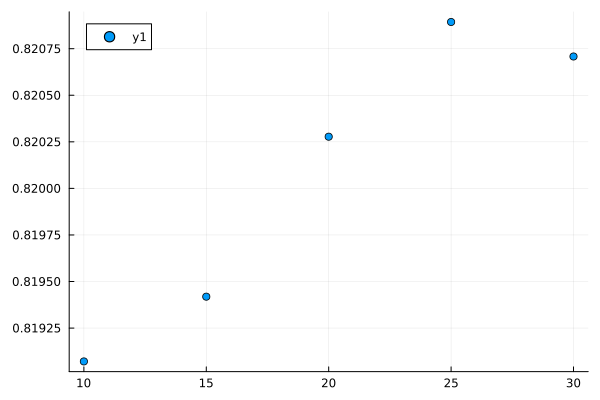

In [19]:
tmp_1 = report(mach_self_tuning_atus_classifier).plotting.parameter_values[:,1]
tmp_2 = report(mach_self_tuning_atus_classifier).plotting.measurements
scatter(tmp_1,tmp_2)

This got a an 82%? That's really good! That's suspiciously good. Let's see if it bears out on the test data.

"4"

In [15]:
ŷ = predict_mode(mach_self_tuning_atus_classifier, X_test)
multiclassf1(ŷ,y_test)

0.19307962992917593

Well, It might be a little over-fit. But that's still the best score we've gotten.

Let's see what the actuall category predictions look like.

# Comparing results

In [69]:
using StatsPlots
using DataFrames

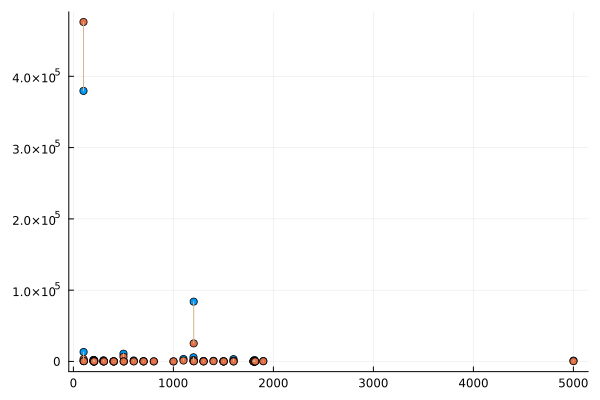

In [150]:
function scatter_count_plot(ŷ, y_test)
    df_ŷ = combine(groupby(DataFrame(class = ŷ), :class), :class => length => :num_predicted)
    df_y_test = combine(groupby(DataFrame(class = y_test), :class), :class => length => :num_actual)
    df_compare = outerjoin(df_ŷ, df_y_test, on=:class)
    DataFrames.transform!(df_compare, :class => (x -> convert.(Integer, x)) => :class)

    scatter(df_compare.class, [df_compare.num_predicted, df_compare.num_actual])
    for i in 1:nrow(df_compare)
        plot!([df_compare.class[i], df_compare.class[i]], [df_compare.num_predicted[i], df_compare.num_actual[i]], color=:tan, legend=:none)
    end
    plot!()
end

scatter_count_plot(ŷ, y_test)

So there are two highly dominant classes here, and these are responsible for the biggest descrepancies.

Let's check the two dominant classes. I bet one is sleep.

In [154]:
sort(combine(groupby(DataFrame(class=y_test), :class), :class => length => :num_actual),:num_actual, rev=true)[1:5,:]

Row,class,num_actual
,Cat…,Int64
1,101,476210
2,1203,25294
3,501,6461
4,102,3235
5,1201,1910


According to [the lexicon](https://www.bls.gov/tus/lexicons/lexiconnoex2021.pdf):
- 101 is sleeping
- 1203 is relaxing and leisure. This includes things like hobbies, reading, and watching TV.
- 501 is working.
- 102 is grooming.
- 1201 is socializing and communicating. This also includes social leisure activities.

Sleep is such a vastly overwhelming activity. We may have more luck if we split this into two models -- the "sleep model" and the "awake model". The sleep model is a simple binary classifier of whether someone is asleep. This is trained on all the data. The awake model is a multiclass classifier determining the person's activity _given they are not sleeping_. This could be trained on the data that is not 101. Sleep basically acts as a hurdle model.

In [7]:
Pkg.add("ClassImbalance")

   Resolving package versions...


Pkg.Resolve.ResolverError: Unsatisfiable requirements detected for package [38;5;3mMLJModels [d491faf4][39m:
 [38;5;3mMLJModels [d491faf4][39m log:
 ├─possible versions are: [38;5;3m0.1.0-0.16.6[39m or uninstalled
 ├─restricted by compatibility requirements with [38;5;14mCategoricalArrays [324d7699][39m to versions: [38;5;3m0.1.0-0.9.10[39m or uninstalled
 │ └─[38;5;14mCategoricalArrays [324d7699][39m log:
 │   ├─possible versions are: [38;5;14m0.3.11-0.10.8[39m or uninstalled
 │   ├─restricted to versions [38;5;14m*[39m by an explicit requirement, leaving only versions [38;5;14m0.3.11-0.10.8[39m
 │   ├─restricted by compatibility requirements with [38;5;13mMLJBase [a7f614a8][39m to versions: [38;5;14m[0.3.11-0.5.5, 0.7.0-0.10.8][39m
 │   │ └─[38;5;13mMLJBase [a7f614a8][39m log:
 │   │   ├─possible versions are: [38;5;13m0.1.0-0.21.9[39m or uninstalled
 │   │   ├─restricted to versions [38;5;13m*[39m by an explicit requirement, leaving only versions [38;5;13m0.1.0-0.21.9[39m
 │   │   ├─restricted by compatibility requirements with [38;5;14mCategoricalArrays [324d7699][39m to versions: [38;5;13m0.1.0-0.13.5[39m or uninstalled, leaving only versions: [38;5;13m0.1.0-0.13.5[39m
 │   │   │ └─[38;5;14mCategoricalArrays [324d7699][39m log: see above
 │   │   ├─restricted by compatibility requirements with [38;5;6mMLJ [add582a8][39m to versions: [38;5;13m[0.1.0-0.2.6, 0.4.0-0.7.5, 0.8.1-0.8.4, 0.9.1-0.12.8, 0.13.1-0.13.10][39m, leaving only versions: [38;5;13m[0.1.0-0.2.6, 0.4.0-0.7.5, 0.8.1-0.8.4, 0.9.1-0.12.8, 0.13.1-0.13.5][39m
 │   │   │ └─[38;5;6mMLJ [add582a8][39m log:
 │   │   │   ├─possible versions are: [38;5;6m0.1.0-0.19.1[39m or uninstalled
 │   │   │   ├─restricted to versions [38;5;6m*[39m by an explicit requirement, leaving only versions [38;5;6m0.1.0-0.19.1[39m
 │   │   │   ├─restricted by compatibility requirements with [38;5;14mCategoricalArrays [324d7699][39m to versions: [38;5;6m0.1.0-0.11.2[39m or uninstalled, leaving only versions: [38;5;6m0.1.0-0.11.2[39m
 │   │   │   │ └─[38;5;14mCategoricalArrays [324d7699][39m log: see above
 │   │   │   └─restricted by compatibility requirements with [38;5;2mTables [bd369af6][39m to versions: [38;5;6m0.9.2-0.19.1[39m or uninstalled, leaving only versions: [38;5;6m0.9.2-0.11.2[39m
 │   │   │     └─[38;5;2mTables [bd369af6][39m log:
 │   │   │       ├─possible versions are: [38;5;2m0.1.0-1.10.1[39m or uninstalled
 │   │   │       └─restricted by compatibility requirements with [38;5;14mStatsPlots [f3b207a7][39m to versions: [38;5;2m1.0.0-1.10.1[39m
 │   │   │         └─[38;5;14mStatsPlots [f3b207a7][39m log:
 │   │   │           ├─possible versions are: [38;5;14m0.10.0-0.15.5[39m or uninstalled
 │   │   │           ├─restricted to versions [38;5;14m*[39m by an explicit requirement, leaving only versions [38;5;14m0.10.0-0.15.5[39m
 │   │   │           └─restricted by compatibility requirements with [38;5;6mClustering [aaaa29a8][39m to versions: [38;5;14m0.14.5-0.15.5[39m or uninstalled, leaving only versions: [38;5;14m0.14.5-0.15.5[39m
 │   │   │             └─[38;5;6mClustering [aaaa29a8][39m log:
 │   │   │               ├─possible versions are: [38;5;6m0.10.0-0.15.1[39m or uninstalled
 │   │   │               ├─restricted to versions [38;5;6m*[39m by an explicit requirement, leaving only versions [38;5;6m0.10.0-0.15.1[39m
 │   │   │               ├─restricted by compatibility requirements with [38;5;14mMLJClusteringInterface [d354fa79][39m to versions: [38;5;6m0.14.0-0.15.1[39m
 │   │   │               │ └─[38;5;14mMLJClusteringInterface [d354fa79][39m log:
 │   │   │               │   ├─possible versions are: [38;5;14m0.1.0-0.1.10[39m or uninstalled
 │   │   │               │   └─restricted to versions [38;5;14m*[39m by an explicit requirement, leaving only versions [38;5;14m0.1.0-0.1.10[39m
 │   │   │               └─restricted by compatibility requirements with [38;5;5mDistances [b4f34e82][39m to versions: [38;5;6m0.14.1-0.15.1[39m or uninstalled, leaving only versions: [38;5;6m0.14.1-0.15.1[39m
 │   │   │                 └─[38;5;5mDistances [b4f34e82][39m log:
 │   │   │                   ├─possible versions are: [38;5;5m0.7.0-0.10.8[39m or uninstalled
 │   │   │                   └─restricted by compatibility requirements with [38;5;14mMLJClusteringInterface [d354fa79][39m to versions: [38;5;5m0.9.0-0.10.8[39m
 │   │   │                     └─[38;5;14mMLJClusteringInterface [d354fa79][39m log: see above
 │   │   └─restricted by compatibility requirements with [38;5;2mTables [bd369af6][39m to versions: [38;5;13m0.11.9-0.21.9[39m or uninstalled, leaving only versions: [38;5;13m[0.11.9-0.12.8, 0.13.1-0.13.5][39m
 │   │     └─[38;5;2mTables [bd369af6][39m log: see above
 │   └─restricted by compatibility requirements with [38;5;4mDataFrames [a93c6f00][39m to versions: [38;5;14m0.3.11-0.7.7[39m, leaving only versions: [38;5;14m[0.3.11-0.5.5, 0.7.0-0.7.7][39m
 │     └─[38;5;4mDataFrames [a93c6f00][39m log:
 │       ├─possible versions are: [38;5;4m0.11.7-1.5.0[39m or uninstalled
 │       ├─restricted to versions [38;5;4m*[39m by an explicit requirement, leaving only versions [38;5;4m0.11.7-1.5.0[39m
 │       ├─restricted by compatibility requirements with [38;5;3mClassImbalance [04a18a73][39m to versions: [38;5;4m0.11.7-0.20.2[39m
 │       │ └─[38;5;3mClassImbalance [04a18a73][39m log:
 │       │   ├─possible versions are: [38;5;3m0.3.0-0.8.7[39m or uninstalled
 │       │   └─restricted to versions [38;5;3m*[39m by an explicit requirement, leaving only versions [38;5;3m0.3.0-0.8.7[39m
 │       └─restricted by compatibility requirements with [38;5;2mTables [bd369af6][39m to versions: [38;5;4m[0.11.7-0.13.1, 0.20.1-1.5.0][39m or uninstalled, leaving only versions: [38;5;4m[0.11.7-0.13.1, 0.20.1-0.20.2][39m
 │         └─[38;5;2mTables [bd369af6][39m log: see above
 ├─restricted by compatibility requirements with [38;5;6mMLJ [add582a8][39m to versions: [38;5;3m0.1.0-0.9.12[39m, leaving only versions: [38;5;3m0.1.0-0.9.10[39m
 │ └─[38;5;6mMLJ [add582a8][39m log: see above
 ├─restricted by compatibility requirements with [38;5;5mDecisionTree [7806a523][39m to versions: [38;5;3m[0.1.0-0.5.0, 0.5.2-0.16.6][39m or uninstalled, leaving only versions: [38;5;3m[0.1.0-0.5.0, 0.5.2-0.9.10][39m
 │ └─[38;5;5mDecisionTree [7806a523][39m log:
 │   ├─possible versions are: [38;5;5m0.8.0-0.12.3[39m or uninstalled
 │   ├─restricted to versions [38;5;5m*[39m by an explicit requirement, leaving only versions [38;5;5m0.8.0-0.12.3[39m
 │   └─restricted by compatibility requirements with [38;5;12mMLJDecisionTreeInterface [c6f25543][39m to versions: [38;5;5m0.10.0-0.12.3[39m
 │     └─[38;5;12mMLJDecisionTreeInterface [c6f25543][39m log:
 │       ├─possible versions are: [38;5;12m0.1.0-0.4.0[39m or uninstalled
 │       ├─restricted to versions [38;5;12m*[39m by an explicit requirement, leaving only versions [38;5;12m0.1.0-0.4.0[39m
 │       └─restricted by compatibility requirements with [38;5;14mCategoricalArrays [324d7699][39m to versions: [38;5;12m0.1.0-0.3.0[39m or uninstalled, leaving only versions: [38;5;12m0.1.0-0.3.0[39m
 │         └─[38;5;14mCategoricalArrays [324d7699][39m log: see above
 ├─restricted by compatibility requirements with [38;5;2mTables [bd369af6][39m to versions: [38;5;3m[0.1.0-0.3.0, 0.8.2-0.16.6][39m or uninstalled, leaving only versions: [38;5;3m[0.1.0-0.3.0, 0.8.2-0.9.10][39m
 │ └─[38;5;2mTables [bd369af6][39m log: see above
 └─restricted by compatibility requirements with [38;5;5mDistances [b4f34e82][39m to versions: [38;5;3m0.11.0-0.16.6[39m or uninstalled — no versions left
   └─[38;5;5mDistances [b4f34e82][39m log: see above

# TESTING AND SCRATCH

In [ ]:
r_tree_n_subfeatures = range(atus_classifier, :(classifier.model.n_subfeatures), lower=1, upper=9, scale=:linear);
r_tree_max_depth = range(atus_classifier, :(classifier.model.max_depth), lower=3, upper=10, scale=:linear)
#r_forest_n = range(atus_classifier, :(classifier.n), lower = 10, upper = 50, scale=:linear)
#r_bagging_fraction = range(atus_classifier, :(classifier.bagging_fraction), lower=0.4, upper=1.0, scale=:linear);
self_tuning_atus_classifier = TunedModel(model=atus_classifier,
									  tuning=Grid(resolution=5),
									  resampling=CV(nfolds=6),
									  range=[r_tree_n_subfeatures, r_tree_max_depth],
									  measure=multiclassf1)

In [ ]:
tuned_mach = machine(self_tuning_atus_classifier, X, y) |> fit!